In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
from astropy.coordinates import search_around_sky   # functional interface

# Local
import util
import utils


In [2]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 300

# Latex related
rc_default['text.usetex'] = False
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [3]:
def mask_radius_for_mag(mag):
    """
    returns a masking radius in degrees for a star of the given magnitude.
    Used for Tycho-2 and Gaia stars.
    This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].

    Parameters
    ----------
    mag : float
        The magnitude of the star.
    Returns
    -------
    float
        The masking radius in degrees.
    """
    return 1630./3600. * 1.396**(-mag)

def mask_radius_DR9(g_mag):
    """
    Legacy Surveys DR9 bright-star mask radius (arcsec) vs Gaia G.
    Parameters
    ----------
    g_mag : float
        The Gaia G magnitude of the star.
    Returns
    -------
    float
        The masking radius in degrees.
    """

    return(0.5 * mask_radius_for_mag(g_mag))



In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [5]:
Legacy_BG_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/BG/full_legacy_no_colour_sel/desi_bg_nomaskbit_mask_4M_with_mag.fits"
Legacy_LRG_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/LRG/v4/LS_DESI_selection_full_sky/reduced/crs_lrg_nogaia_nomaskbit_mask_4M_reduced_columns.fits"

In [6]:
SGA_parent_path = "/its/home/bb345/5-4most_data/other_data/LS_dr10_maskings/SGA-parent-v3.0.kd.fits"

In [ ]:
BG = Table.read(Legacy_BG_path)
# LRG = Table.read(Legacy_LRG_path)


In [15]:
SGA_parent = Table.read(SGA_parent_path)

In [8]:
BG

RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_W1,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_W1,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,WISE_COADD_ID,SHAPE_R,SHAPE_R_IVAR,SHAPE_E1,SHAPE_E1_IVAR,SHAPE_E2,SHAPE_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_I,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_I,FIBERTOTFLUX_Z,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS,FITBITS,SERSIC,SERSIC_IVAR,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,CRS_mask,isBG_4M_v2,desi_selection,l,b,galactic_cap,dr1_bg_mask
int16,int32,bytes8,int32,bytes3,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int64,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,float32,float32,bool,bool,bool,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,bytes3,bool
10000,318036,1571m022,419,SER,157.0072201498557,-2.1468467554514508,2829613000000.0,1263612300000.0,0.044455066,4.622516,18.179604,30.817358,44.562187,74.4045,653.8463,110.50771,66.312546,28.440388,2.021425,0.8766951,0.9151703,0.9368952,0.9516253,0.9924945,0,0,0,0,0,0,0,0,0,0,1.4278785,1.3295078,1.8586007,1.2330554,2375.1145,548.0492,196.52733,127.81866,1422.1688,319.87708,133.46909,65.57631,4.425603,0.7773627,1573m016,1.2885218,62885.664,0.4635108,93870.5,0.31089413,89897.664,1.6738261,6.5828853,11.159052,16.136093,1.6738355,6.582907,11.159085,16.136158,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2.4836926,552.2476,False,False,True,19.25479382276535,18.3237487077713,20.69492533802986,18.707239031791687,17.81282216310501,True,False,False,247.4593621394637,44.7305951818517,NGC,True
10000,318036,1571m022,645,REX,157.01433423838904,-2.2641702674806825,660991600000.0,651630200000.0,0.041389566,14.7765,25.365751,32.48336,37.945354,28.925161,181.6212,53.165123,55.583916,16.975594,2.5108273,0.8846868,0.9207816,0.9411159,0.9548846,0.9930102,0,0,0,0,0,0,0,0,0,0,1.4254465,1.2035409,1.809292,1.0097861,1487.4917,571.6015,285.5481,192.48973,932.1067,312.49435,194.77615,87.89875,4.425603,0.7773627,1573m016,1.4365712,63760.695,0.0,0.0,0.0,0.0,2.68455,4.608373,5.9014792,6.8937974,2.687711,4.6111884,5.9031386,6.896769,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,False,False,True,18.89977216720581,18.50198060274124,19.44304496049881,18.654955327510834,18.839194774627686,True,False,False,247.58716939163293,44.656025969151756,NGC,True
10000,318036,1571m022,838,REX,157.0200785116195,-2.3639337222354797,5334776000000.0,5336928000000.0,0.039800275,13.1672945,25.108688,32.493122,38.05644,18.862955,2401.8557,281.5401,45.671402,38.67789,3.0797968,0.8888588,0.92370427,0.94331163,0.9565788,0.9932777,2048,0,0,0,0,0,0,0,0,0,1.2322137,1.3594674,2.0637183,1.2472955,16465.09,1571.8876,131.6708,184.63194,8756.951,903.41583,93.984375,97.305885,4.4771605,0.7794657,1573m031,0.96308136,454774.9,0.0,0.0,0.0,0.0,3.860367,7.361326,9.526283,11.157327,3.8618104,7.363851,9.529066,11.160823,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,False,False,True,18.91427218914032,18.500731587409973,19.57334041595459,18.657159507274628,19.303652346134186,True,False,False,247.69529638239084,44.592282112837864,NGC,True
10000,318036,1571m022,1164,REX,157

In [9]:
BG = BG[(BG['isBG_4M_v2'] == True)]
BG.keep_columns(['RA', 'DEC', 'in_S8', 'MASKBITS', 'isBG_4M_v2'])


In [10]:
BG = BG.to_pandas()


In [ ]:
# LRG = LRG[(LRG['in_S8_v2'] == True)]
# LRG.keep_columns(['RA', 'DEC', 'in_S8', 'MASKBITS', 'in_S8_v2'])


In [ ]:
# LRG = LRG.to_pandas()

In [16]:
SGA_parent.keep_columns(['RA', 'DEC'])

In [17]:
SGA_parent = SGA_parent.to_pandas()

In [21]:
SGA_parent = SGA_parent[SGA_parent['DEC']<40]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


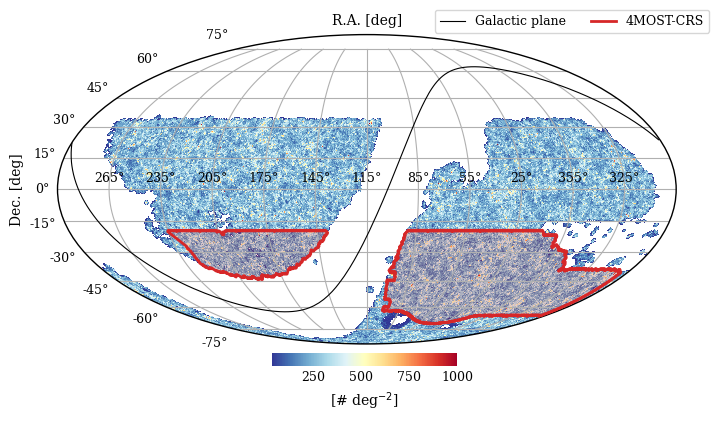

In [17]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

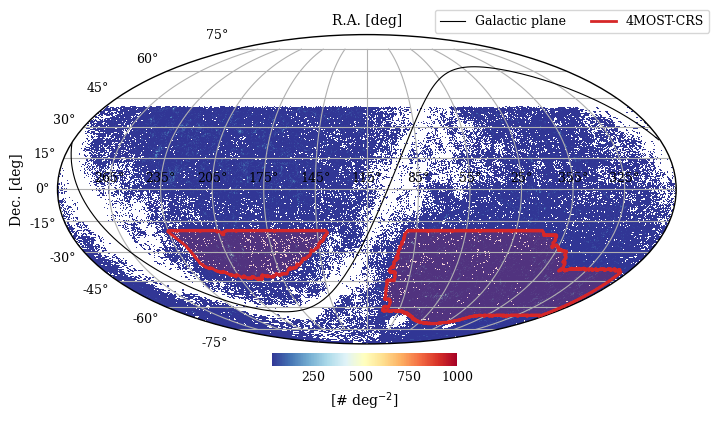

In [20]:
hpmap = utils.create_hp_map(SGA_parent['RA'][SGA_parent['DEC']<40], SGA_parent['DEC'][SGA_parent['DEC']<40], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

In [22]:
# bright   = SGA_parent          # contiguous 0…N−1
stars    = SkyCoord(SGA_parent['RA'].values * u.deg,
                    SGA_parent['DEC'].values * u.deg)

In [85]:
R_DR9 = 1 / 60.0       # degrees
R_outer = 4 * R_DR9              # degrees
print(f"R_max = {R_outer:.2f} degrees")

R_max = 0.07 degrees


In [86]:
# ------------------ one-off SkyCoord creation for BG ------------------
BG_cats = SkyCoord(ra=BG['RA'].values * u.deg,
                dec=BG['DEC'].values * u.deg)
# LRG_cats = SkyCoord(ra=LRG['RA'].values * u.deg,
#                 dec=LRG['DEC'].values * u.deg)

In [87]:
sidx_BG, gidx_BG, sep2d_BG, _ = search_around_sky(stars, BG_cats, R_outer * u.deg)
# sidx_LRG, gidx_LRG, sep2d_LRG, _ = search_around_sky(stars, LRG_cats, R_outer * u.deg)


In [133]:
# 4.  Clip to < 4 × the *individual* star’s mask radius
keep          = sep2d_BG.value <= (R_outer)
sidx, gidx    = sidx_BG[keep], sidx_BG[keep]

In [135]:
ra_bg, dec_bg = BG_cats[gidx_BG].ra.deg, BG_cats[gidx_BG].dec.deg
# ra_lrg, dec_lrg = LRG_cats[gidx_LRG].ra.deg, LRG_cats[gidx_LRG].dec.deg
ra_st_bg, dec_st_bg = stars[sidx_BG].ra.deg, stars[sidx_BG].dec.deg
# ra_st_lrg, dec_st_lrg = stars[sidx_LRG].ra.deg, stars[sidx_LRG].dec.deg

In [136]:
dRAc_BG = (ra_bg - ra_st_bg) * np.cos(dec_st_bg)
dDec_BG = dec_bg - dec_st_bg
# dRAc_LRG = (ra_lrg - ra_st_lrg) * np.cos(dec_st_lrg)
# dDec_LRG = dec_lrg - dec_st_lrg

In [137]:
x_BG = dRAc_BG * 3600.0 
y_BG = dDec_BG * 3600.0

# x_LRG = dRAc_LRG * 3600.0
# y_LRG = dDec_LRG * 3600.0

In [146]:
nbins = 200

In [147]:
H_BG, xe_BG, ye_BG = np.histogram2d(x_BG, y_BG, bins=nbins, range=[[-R_outer*3600,R_outer*3600],[-R_outer*3600,R_outer*3600]])
# H_LRG, xe_LRG, ye_LRG = np.histogram2d(x_LRG, y_LRG, bins=nbins, range=[[-4*120,4*120],[-4*120,4*120]])


In [148]:
Xc_BG, Yc_BG = (xe_BG[:-1]+xe_BG[1:]), (ye_BG[:-1]+ye_BG[1:])
XX, YY = np.meshgrid(Xc_BG,Yc_BG)
R = np.sqrt(XX**2 + YY**2)
mask = (XX>200) & (XX<400) & (YY>200) & (YY<400)
eta_mean = H_BG[mask].mean()
density_ratio = H_BG / eta_mean
# density_ratio[R>400] = np.nan  # mask out values outside the circle

# Xc_LRG, Yc_LRG = (xe_LRG[:-1]+xe_LRG[1:]), (ye_LRG[:-1]+ye_LRG[1:])
# XX_LRG, YY_LRG = np.meshgrid(Xc_LRG,Yc_LRG)
# R_LRG = np.sqrt(XX_LRG**2 + YY_LRG**2)
# mask_LRG = (R_LRG>1.1) & (R_LRG<4)
# eta_mean_LRG = H_LRG[mask_LRG].mean()

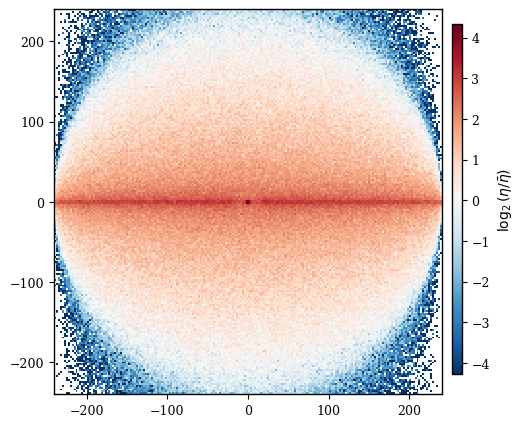

In [149]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(5, 5))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# 9. Plot
# fig, ax = plt.subplots(figsize=(6,6))
pcm = ax.pcolormesh(xe_BG, ye_BG, np.log2(density_ratio), cmap='RdBu_r')

    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
# for rad, col in [(1,'k'), (2,'b')]:
#     circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=1, ec=col)
#     ax.add_patch(circ)
# ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
#     transform=ax.transAxes, fontsize=20, verticalalignment='top',
#     horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
# ax.set_xlim(-5,5)
# ax.set_ylim(-5,5)
# ax.axhline(0, color='k', lw=0.5, ls='--')
# ax.axvline(0, color='k', lw=0.5, ls='--')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')


In [85]:
hist_range = 4
deltar_size = 0.05
bin_number = int(2*hist_range/deltar_size)

In [86]:
bin_number

160

In [121]:
overdensity_dict = {}

R_max = 0.11 degrees
R_max = 0.03 degrees
R_max = 0.02 degrees
R_max = 0.01 degrees


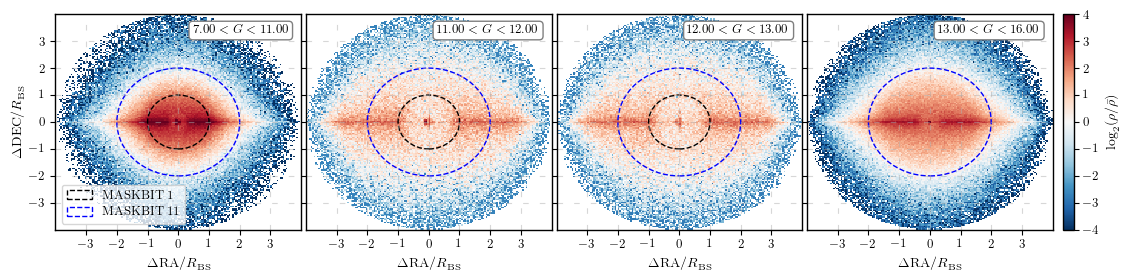

In [122]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten() if nrows * ncols > 1 else [axes]
for i, mag_bin in enumerate(mag_bins):
    ax = axes[i]
    sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
    bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
    stars    = SkyCoord(bright['RA'].values * u.deg,
                        bright['DEC'].values * u.deg)

    R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
    R_outer = 5.0 * R_DR9.max()                    # degrees
    print(f"R_max = {R_outer:.2f} degrees")

    sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)

    # 4.  Clip to < 4 × the *individual* star’s mask radius
    keep          = sep2d.value <= (4.0 * R_DR9[sidx])
    sidx, gidx    = sidx[keep], gidx[keep]

    ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
    ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

    dRAc = (ra_bg - ra_st) * np.cos(dec_st)
    dDec = dec_bg - dec_st

    # ra_bg_plot, dec_bg_plot = cats[gidx_plot].ra.deg, cats[gidx_plot].dec.deg
    # ra_st_plot, dec_st_plot = stars[sidx_plot].ra.deg, stars[sidx_plot].dec.deg

    # dRAc_plot = (ra_bg_plot - ra_st_plot) * np.cos(dec_st_plot)
    # dDec_plot = dec_bg_plot - dec_st_plot

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[sidx]
    R9_arcsec   = max(mask_radius_DR9(mags_at_idx)) * 3600.0  # convert to arcsec
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    H, xe, ye = np.histogram2d(x, y, bins=bin_number, range=[[-hist_range,hist_range],[-hist_range,hist_range]])

    Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)

    mask = (R>1.1) & (R<8)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    density_ratio[R>8] = np.nan  # mask out values outside the circle
    mask_radius_lable = ['MASKBIT 1', 'MASKBIT 11']

    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio), cmap='RdBu_r', vmin=-4, vmax=4)

    overdensity_dict[i] = {
        'pcm': pcm,
        'mag_bin': mag_bin,
        'R_outer': R_outer,
        'xe': xe,
        'ye': ye,
        'density_ratio': density_ratio,
    }

        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    if mag_bin[1]<=13:
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    else:
        for rad, col in [(2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col,label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    
    # for rad, col in [(1,'k'), (2,'b')]:
        # circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        # ax.add_patch(circ)
    
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()

In [125]:
import pickle

with open('overdensity_dict_bg.pkl', 'wb') as f:
    pickle.dump(overdensity_dict, f)

R_max = 0.11 degrees
R_max = 0.03 degrees
R_max = 0.02 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees


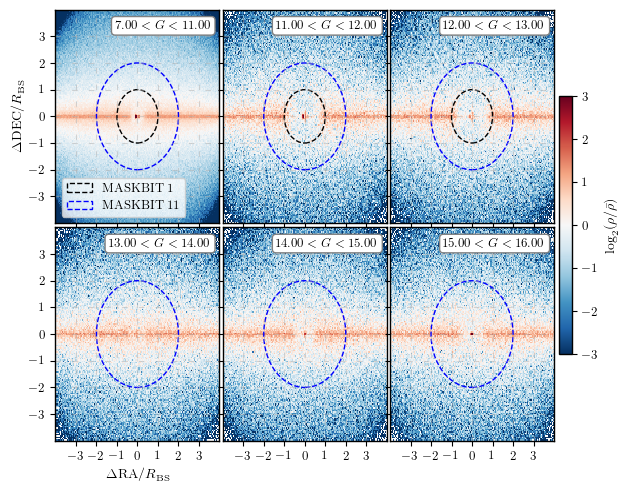

In [89]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*2, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten() if nrows * ncols > 1 else [axes]
for i, mag_bin in enumerate(mag_bins):
    ax = axes[i]
    sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
    bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
    stars    = SkyCoord(bright['RA'].values * u.deg,
                        bright['DEC'].values * u.deg)

    R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
    R_outer = 5.0 * R_DR9.max()                    # degrees
    print(f"R_max = {R_outer:.2f} degrees")

    sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)

    # 4.  Clip to < 4 × the *individual* star’s mask radius
    keep          = sep2d.value <= (4.0 * R_DR9[sidx])
    # sidx, gidx    = sidx[keep], gidx[keep]

    ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
    ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

    dRAc = (ra_bg - ra_st) * np.cos(dec_st)
    dDec = dec_bg - dec_st

    # ra_bg_plot, dec_bg_plot = cats[gidx_plot].ra.deg, cats[gidx_plot].dec.deg
    # ra_st_plot, dec_st_plot = stars[sidx_plot].ra.deg, stars[sidx_plot].dec.deg

    # dRAc_plot = (ra_bg_plot - ra_st_plot) * np.cos(dec_st_plot)
    # dDec_plot = dec_bg_plot - dec_st_plot

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[sidx]
    R9_arcsec   = max(mask_radius_DR9(mags_at_idx)) * 3600.0  # convert to arcsec
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    H, xe, ye = np.histogram2d(x, y, bins=bin_number, range=[[-hist_range,hist_range],[-hist_range,hist_range]])

    Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)

    mask = (R>2) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    # density_ratio[R>8] = np.nan  # mask out values outside the circle
    mask_radius_lable = ['MASKBIT 1', 'MASKBIT 11']

    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio), cmap='RdBu_r', vmin=-3, vmax=3)

        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    if mag_bin[1]<=13:
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    else:
        for rad, col in [(2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col,label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    
    # for rad, col in [(1,'k'), (2,'b')]:
        # circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        # ax.add_patch(circ)
    
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
# plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
# plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()

R_max = 0.09 degrees


R_max = 0.02 degrees
R_max = 0.02 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees


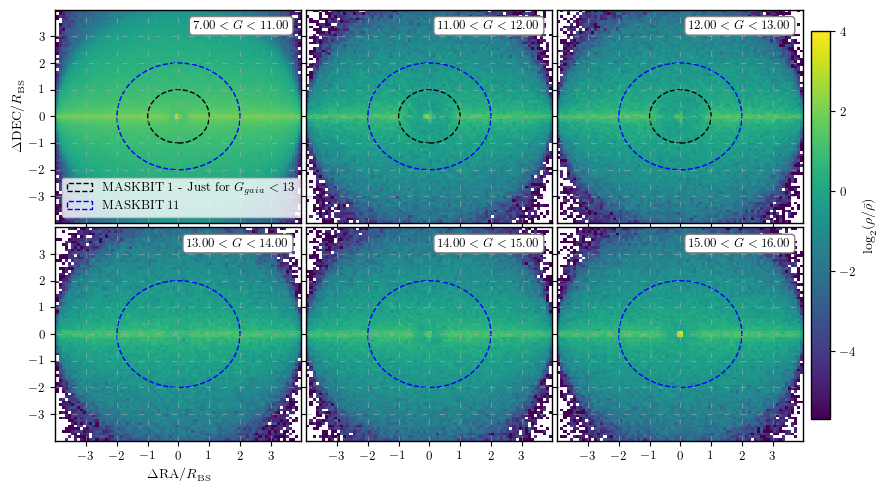

In [96]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten() if nrows * ncols > 1 else [axes]
for i, mag_bin in enumerate(mag_bins):
    ax = axes[i]
    sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
    bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
    stars    = SkyCoord(bright['RA'].values * u.deg,
                        bright['DEC'].values * u.deg)

    R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
    R_outer = 4.0 * R_DR9.max()                    # degrees
    print(f"R_max = {R_outer:.2f} degrees")

    sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)

    # 4.  Clip to < 4 × the *individual* star’s mask radius
    keep          = sep2d.value <= (4.0 * R_DR9[sidx])
    sidx_plot, gidx_plot    = sidx[keep], gidx[keep]

    ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
    ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

    dRAc = (ra_bg - ra_st) * np.cos(dec_st)
    dDec = dec_bg - dec_st

    ra_bg_plot, dec_bg_plot = cats[gidx_plot].ra.deg, cats[gidx_plot].dec.deg
    ra_st_plot, dec_st_plot = stars[sidx_plot].ra.deg, stars[sidx_plot].dec.deg

    dRAc_plot = (ra_bg_plot - ra_st_plot) * np.cos(dec_st_plot)
    dDec_plot = dec_bg_plot - dec_st_plot

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[sidx]
    R9_arcsec   = max(mask_radius_DR9(mags_at_idx)) * 3600.0  # convert to arcsec
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-10,10],[-10,10]])

    Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)

    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']

    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio),
                            vmax=4)

        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    if mag_bin[1]<=13:
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    else:
        for rad, col in [(2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col,label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    
    # for rad, col in [(1,'k'), (2,'b')]:
        # circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        # ax.add_patch(circ)
    
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
# plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
# plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()